In [146]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [147]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.308725,0.235825,0.566757,0.982782,0.707526,1.000000,0.410887,0.671068,1.000000,0.438527
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.861588,0.000000,0.640911,0.020238,0.220356,0.632252,0.000000,0.488578
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.491401,0.279122,0.555258,0.000000,0.392175,0.000000,0.116289,0.000000,0.260194,0.531400
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.604918,0.598850,0.621841,0.000000,0.519941,0.000000,0.342185,0.416527,0.000000,0.545708
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.470835,0.670696,0.555250,0.000000,0.390923,0.000000,0.498504,0.449224,0.000000,0.689242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.669319,0.770253,0.702931,0.000000,0.451846,0.000000,0.319644,0.549587,0.000000,0.935108
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.747236,0.742399,0.730485,0.000000,0.680460,0.000000,0.280413,0.529434,0.000000,0.606330
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.422981,0.769213,0.625325,0.000000,0.374319,0.000000,0.396084,0.590976,0.238307,0.753111


In [148]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.775985,0.973492,0.472825,0.0,0.269797,0.0,0.539781,0.290165,0.000000,0.722611
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.582213,0.531660,0.540145,0.0,0.322049,0.0,0.303573,0.133159,0.000000,0.537012
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.907365,0.736128,-0.336653,0.0,-0.069528,0.0,0.176989,0.766373,0.000000,1.094845
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.648501,0.789699,0.836996,0.0,0.285660,0.0,0.320280,0.488913,0.000000,0.674738
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.493294,0.566990,0.807264,0.0,0.471971,0.0,0.462733,0.508932,0.000000,0.693707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.550182,0.719685,0.701615,0.0,0.225656,0.0,0.295914,0.701896,0.000000,0.709542
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.819116,0.689739,0.213157,0.0,0.969447,0.0,0.134090,0.710444,0.000000,0.846294
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.417027,0.734039,0.683655,0.0,0.369566,0.0,0.405814,0.575430,0.000000,0.653918


In [149]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [150]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [151]:
# compound_model = keras.models.load_model('cd_clf')

In [152]:
# compound_model.summary()

## SHAP evaluation

In [153]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [154]:
import objects

In [155]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True)

## Calculate SHAP values

In [156]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [157]:
# shap_values

## Save SHAP values

In [158]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [159]:


with open("../data/models/shap/new_fd_all_1samp", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [160]:
shap_values = shap_values[0]


In [161]:
# for i in range(3):
#     shap_values[i] /= 100

In [162]:
shap_values

[array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   1.35103567],
        [  0.        ,   6.17831631,  -5.73639351, ...,   0.        ,
          -6.70734293,  12.49391085],
        [-52.59459691,  22.86507183,   0.        , ..., -29.90442705,
         -27.85473636, -28.41068217],
        ...,
        [ -7.27663823,   0.        ,   0.        , ...,   0.        ,
           0.        ,   5.24897063],
        [ 19.8262287 ,  28.32496178, -31.04260013, ...,  -6.55965035,
         -40.64026861, -20.73298093],
        [ -0.1985122 ,  -2.52800181,   1.53332876, ...,   0.        ,
           1.54098934,   0.        ]]),
 array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    9.69034901,   -4.58313771, ...,  -64.09163997,
          126.44603309,  -99.72736733],
        [  -2.71615433,    0.        ,   46.56861502, ...,  111.17131643,
           44.15366851,    0.      

In [163]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [242]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.73261,0.822309,0.569633,0.0,0.590696,0.0,0.341364,0.322348,0.0,0.664423


In [243]:
gmm_model_get_prediction_ae(patient)[0]

array([6.45138187e-10, 9.94654725e-01, 5.34527417e-03])

In [244]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

#### Control

In [245]:
import shap

In [246]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [247]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [248]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [249]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

_explanation.Explanation

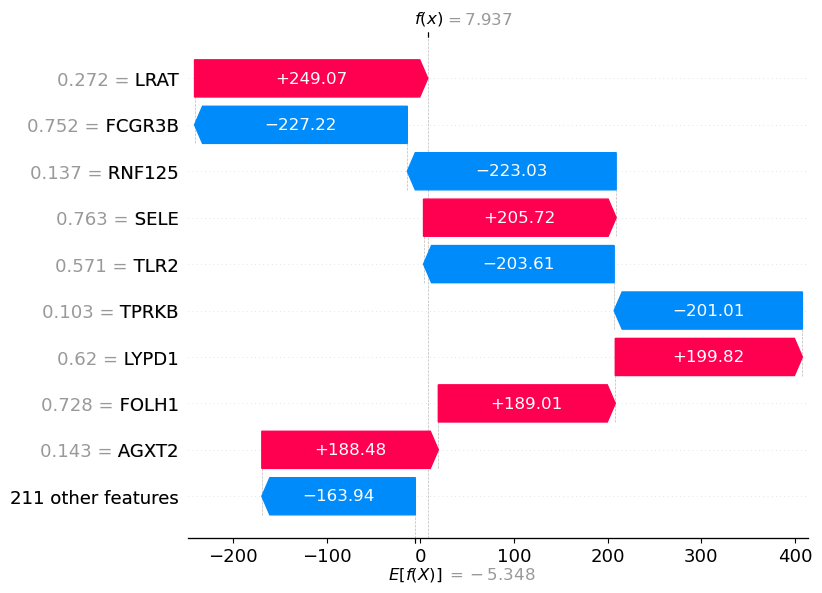

In [250]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [173]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [174]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [175]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

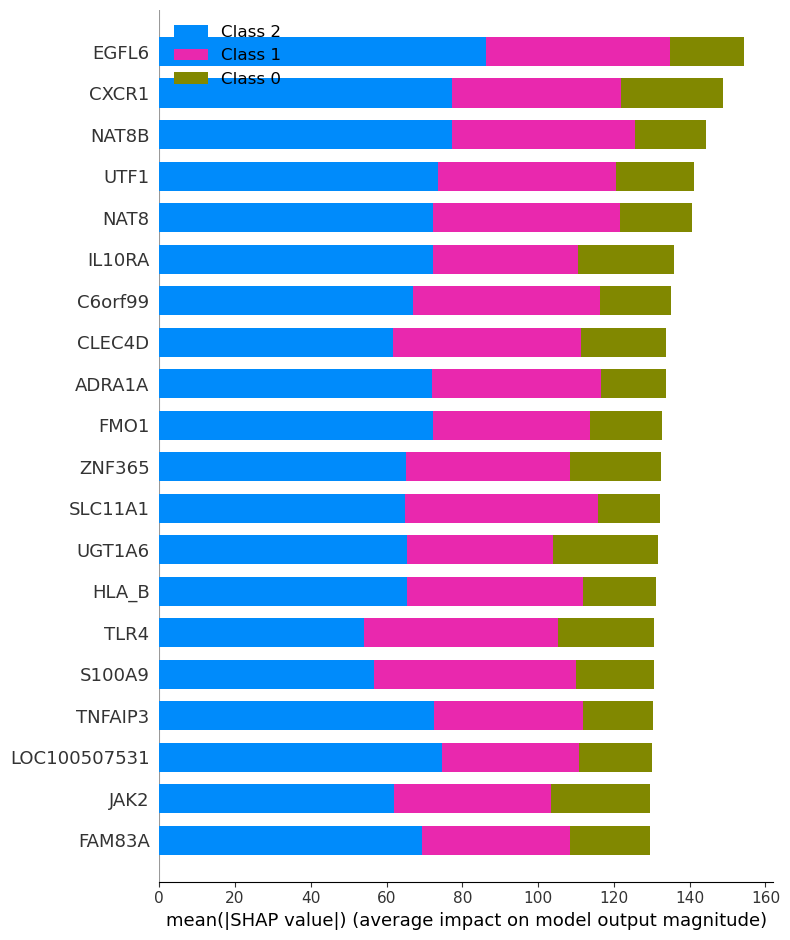

In [176]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


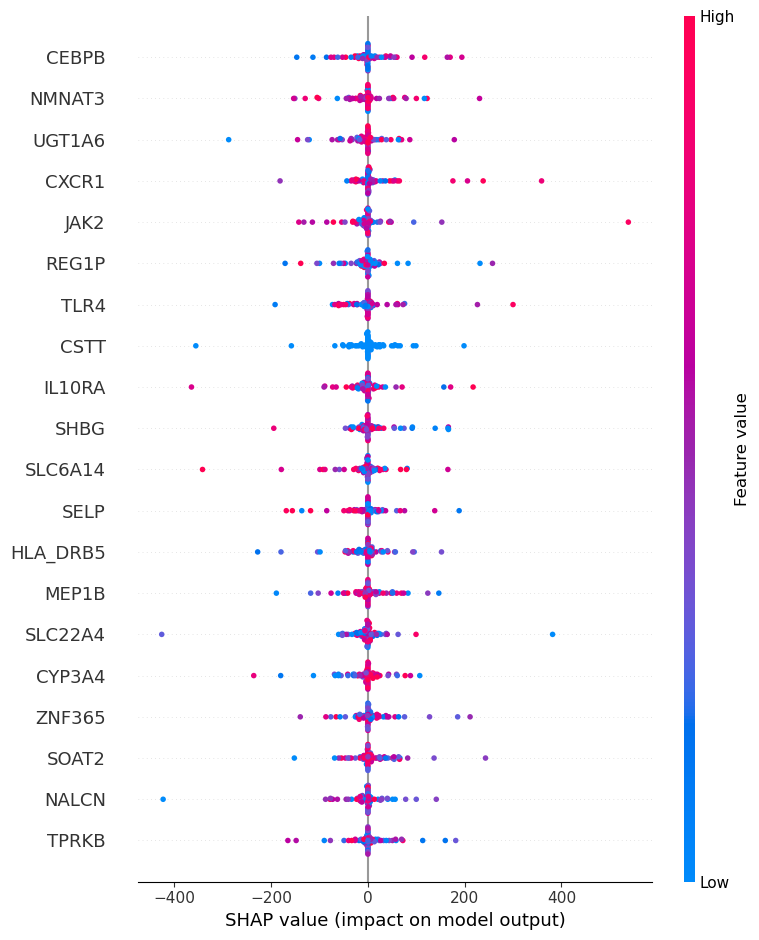

In [177]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

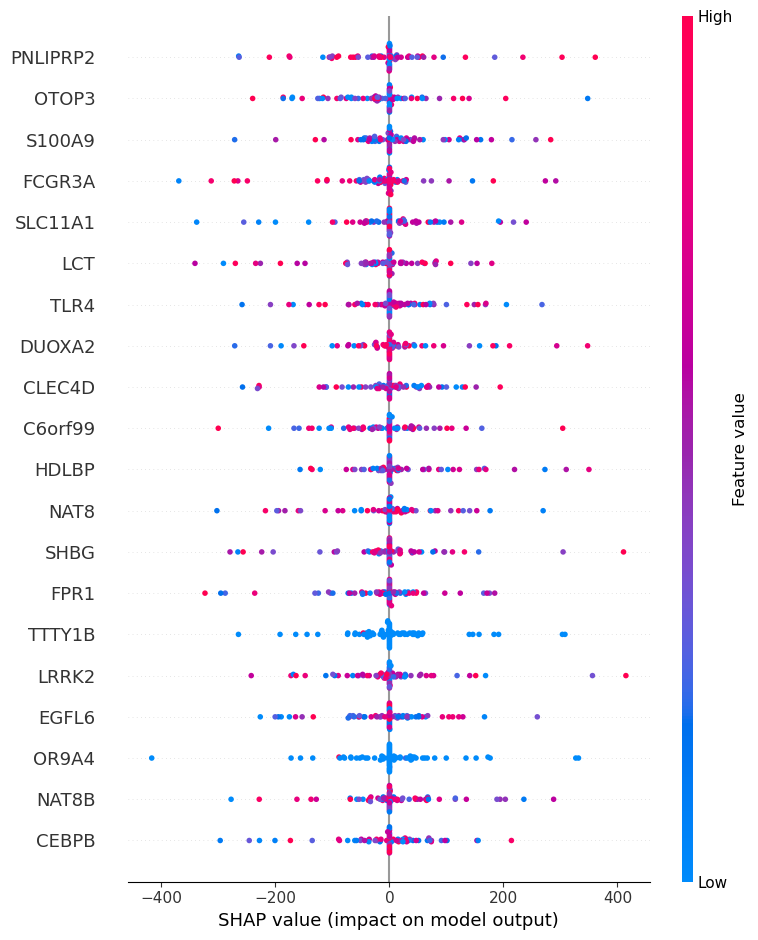

In [178]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

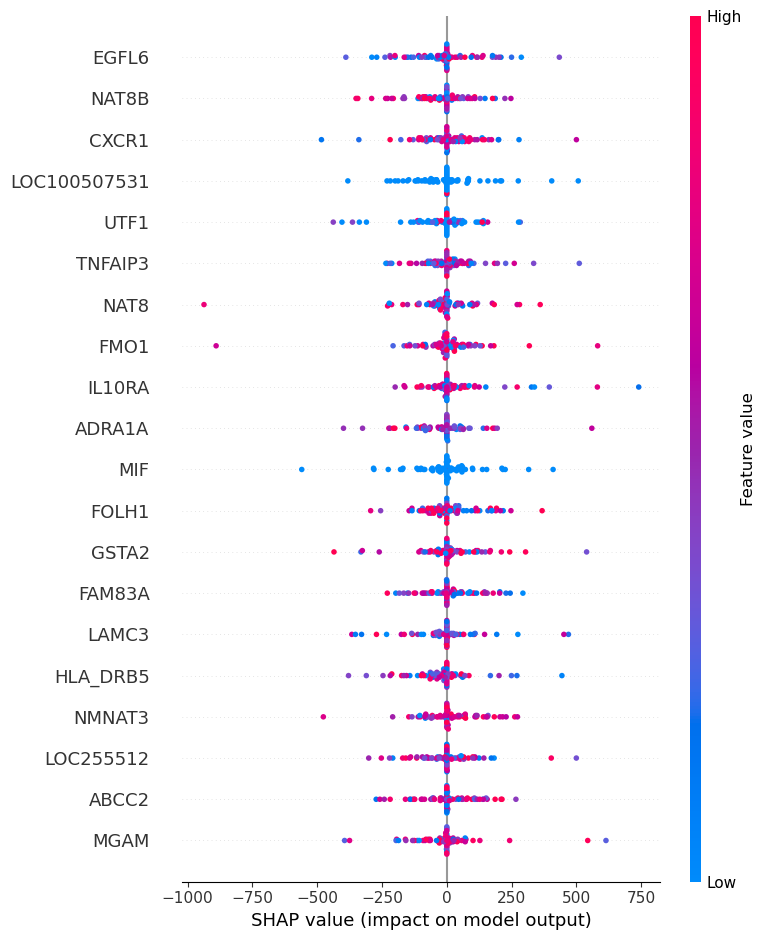

In [179]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

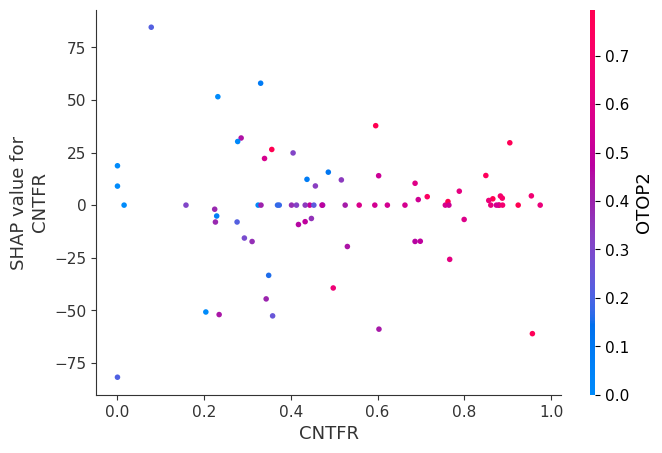

In [180]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

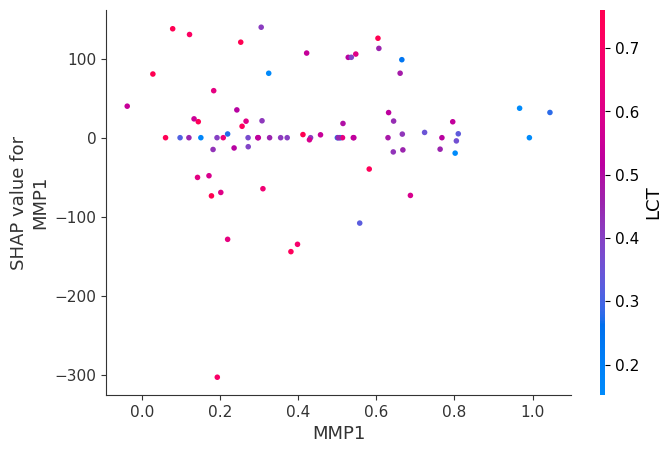

In [181]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

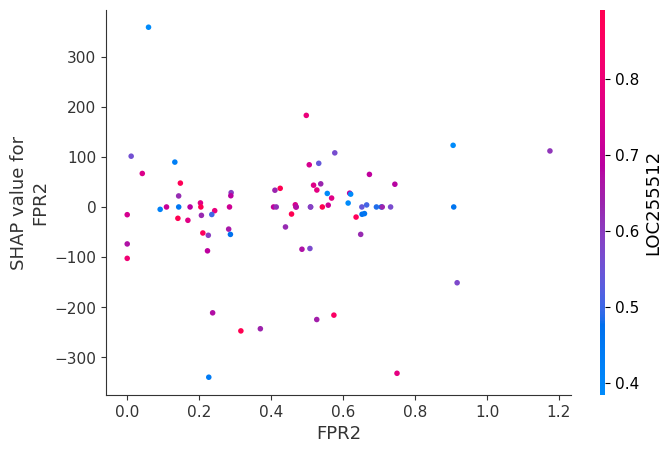

In [182]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [183]:
disease_labels_test.shape

(78,)

In [184]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [185]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 78%|██████████████████████████████████████████████████████████████▌                 | 172/220 [01:09<00:19,  2.52it/s]No/low signal found from feature 171 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 172 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 98%|██████████████████████████████████████████████████████████████████████████████▌ | 216/220 [01:25<00:01,  3.34it/s]No/low signal found from feature 215 (this is typically cause

In [186]:
# clustering

In [187]:
# clustering.shape

In [188]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [189]:
type(exp)

shap._explanation.Explanation

In [190]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [191]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

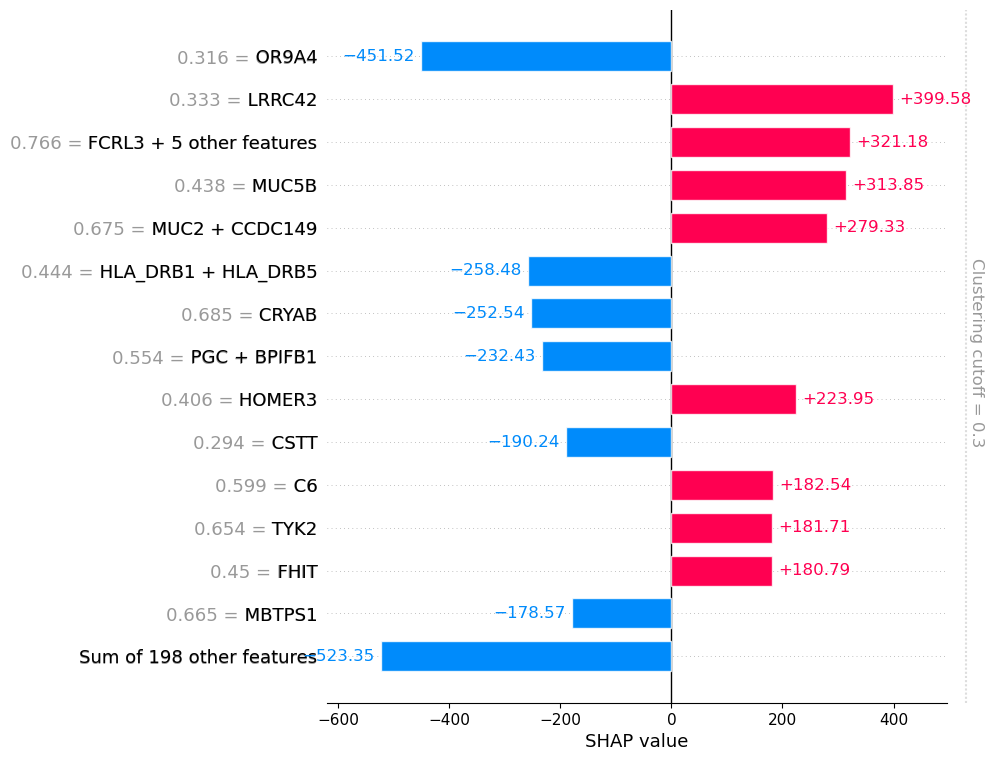

In [192]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [193]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [194]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,50.852145,-136.867860,51.487993,88.707798,28.019145,93.038169,0.000000,60.935960,...,54.508889,-110.685573,-197.043981,-39.431901,293.623327,0.000000,0.000000,-41.169747,0.000000,0.000000
167_CD_deep_ulcer,20.736738,-109.598004,19.216275,-152.517459,0.000000,36.302068,47.081850,21.280506,-17.986099,0.000000,...,-140.048718,118.227646,0.000000,-2.279625,-78.577132,-25.363698,18.602593,34.503705,0.000000,-77.340670
196_CD_deep_ulcer,18.364899,-322.425384,-5.248103,478.981866,-222.071309,-159.800878,6.948212,-82.466021,13.355869,138.878368,...,200.917556,342.845082,-74.274514,-79.222599,-59.560180,-210.211813,0.000000,22.078414,0.000000,44.563722
23_CD_deep_ulcer,3.409721,-14.666490,0.000000,0.000000,0.000000,-21.923804,21.526257,0.000000,0.000000,0.000000,...,-16.230587,0.000000,54.484656,0.000000,6.551921,7.736056,0.441777,9.472541,55.865766,12.214593
93_CD_deep_ulcer,218.719821,-214.245456,-122.478159,-92.915434,-57.590956,-48.152799,0.000000,13.472210,-49.292928,266.637553,...,-12.235668,-280.071075,0.000000,78.125256,145.480498,296.382245,17.830426,0.000000,113.981815,-8.654971
229_CD_deep_ulcer,9.962126,0.000000,-33.640446,-213.803637,-85.877620,-148.021285,0.000000,0.000000,-96.374469,0.000000,...,0.000000,-1.455484,0.000000,0.000000,203.807070,33.764758,0.000000,0.000000,0.000000,-43.588362
46_CD_deep_ulcer,-82.708659,0.000000,112.946155,-83.013850,26.553716,-65.970923,-52.226706,20.831719,0.000000,20.351945,...,-20.788020,-21.390489,64.053141,-117.947421,178.952545,-25.863107,-223.031041,-16.714586,20.339932,30.717584
176_CD_deep_ulcer,0.000000,-104.442361,-34.032118,-158.728426,21.012269,95.745460,0.000000,8.931119,0.000000,-6.728256,...,0.000000,41.807293,0.000000,11.187291,101.088290,12.342523,95.149752,-26.885854,-64.674778,-30.758121
49_CD_deep_ulcer,0.000000,167.604740,-23.397042,0.000000,15.534907,126.135059,0.000000,0.000000,-29.448354,10.392576,...,0.000000,0.000000,-35.390323,0.000000,81.343348,-12.849268,54.285204,-68.881453,12.657766,-63.721142


### Example: CD deep ulcer patients

In [195]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

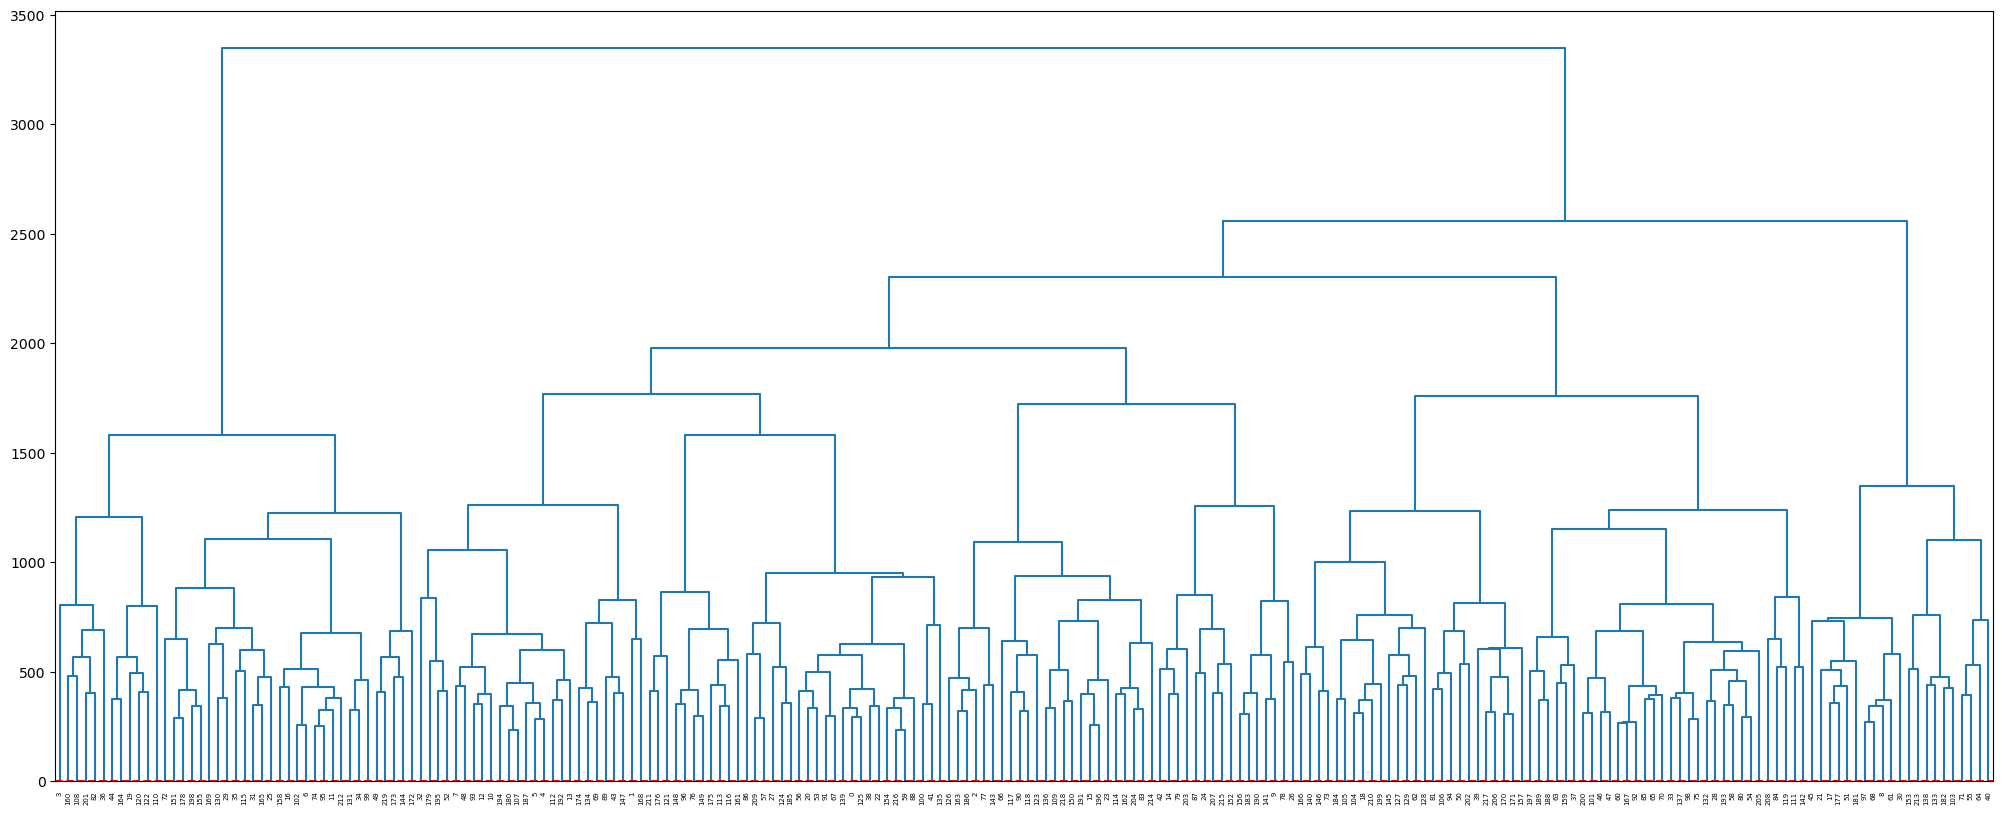

In [196]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [197]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([  3, 160, 108, 201,  82,  36,  44, 164,  19, 120, 122, 110,  72,
       151, 178, 198, 155, 169, 130,  29,  35, 115,  31, 165,  25, 158,
        16, 102,   6,  74,  95,  11, 212, 131,  34,  99,  49, 219, 173,
       144, 172,  32, 179, 195,  52,   7,  48,  93,  12,  10, 194, 180,
       107, 187,   5,   4, 112, 192,  13, 174, 134,  69,  89,  43, 147,
         1, 168, 211, 176, 121, 148,  96,  76, 149, 175, 113, 116, 161,
        86, 209,  57,  27, 124, 185,  56,  20,  53,  91,  67, 139,   0,
       125,  38,  22, 154, 216,  59,  88, 100,  41, 135, 126, 163, 186,
         2,  77, 143,  66, 117,  90, 118, 123, 136, 109, 218, 150, 191,
        15, 196,  23, 114, 162, 204,  83, 214,  42,  14,  79, 203,  87,
        24, 207, 215, 152, 156, 183, 190, 141,   9,  78,  26, 166, 140,
       146,  73, 184, 105, 104,  18, 210, 199, 145, 127, 129,  62, 128,
        81, 106,  94,  50, 202,  39, 217, 206, 170, 171, 157, 197, 189,
       188,  63, 159,  37, 200, 101,  46,  47,  60, 167,  92,  8

In [198]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

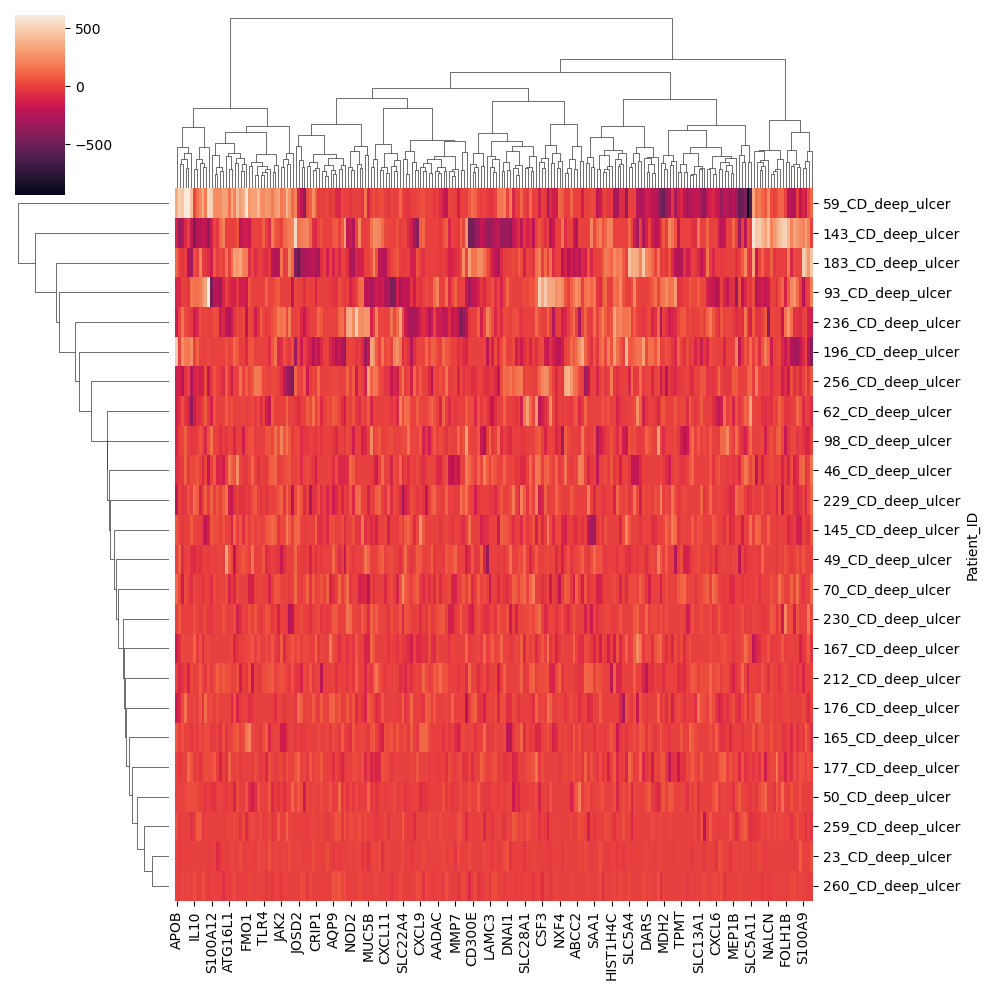

In [199]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [200]:
gene_cluster_cd_deep

array([[1.80000000e+02, 1.07000000e+02, 2.31604940e+02, 2.00000000e+00],
       [2.16000000e+02, 5.90000000e+01, 2.32374235e+02, 2.00000000e+00],
       [7.40000000e+01, 9.50000000e+01, 2.50850226e+02, 2.00000000e+00],
       [1.50000000e+01, 1.96000000e+02, 2.54604045e+02, 2.00000000e+00],
       [1.02000000e+02, 6.00000000e+00, 2.54887917e+02, 2.00000000e+00],
       [6.00000000e+01, 1.67000000e+02, 2.67499235e+02, 2.00000000e+00],
       [9.70000000e+01, 6.80000000e+01, 2.70981478e+02, 2.00000000e+00],
       [2.25000000e+02, 9.20000000e+01, 2.72212110e+02, 3.00000000e+00],
       [9.80000000e+01, 7.50000000e+01, 2.85225925e+02, 2.00000000e+00],
       [5.00000000e+00, 4.00000000e+00, 2.85437471e+02, 2.00000000e+00],
       [2.09000000e+02, 5.70000000e+01, 2.86814518e+02, 2.00000000e+00],
       [1.51000000e+02, 1.78000000e+02, 2.87175790e+02, 2.00000000e+00],
       [0.00000000e+00, 1.25000000e+02, 2.92097751e+02, 2.00000000e+00],
       [8.00000000e+01, 5.40000000e+01, 2.92725397e

In [201]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [202]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([160, 108, 201,  82,  36,   3,  44, 164, 120, 122,  19, 110, 151,
        178, 198, 155,  72, 130,  29, 169,  35, 115,  31, 165,  25, 158,
         16, 102,   6,  74,  95,  11, 212, 131,  34,  99,  49, 219, 173,
        144, 172, 195,  52, 179,  32,   7,  48,  93,  12,  10, 180, 107,
        194,   5,   4, 187, 112, 192,  13, 134,  69, 174,  43, 147,  89,
          1, 168, 211, 176, 121, 148,  96,  76, 149, 113, 116, 175, 161,
        209,  57,  86, 124, 185,  27,  20,  53,  56,  91,  67,   0, 125,
        139,  38,  22, 216,  59, 154,  88, 100,  41, 135, 163, 186,   2,
        126,  77, 143,  90, 118, 117, 123,  66, 136, 109, 218, 150,  15,
        196, 191,  23, 114, 162, 204,  83, 214,  14,  79,  42, 203,  87,
         24, 207, 215, 152, 156, 183, 190, 141,   9,  78,  26, 166, 140,
        146,  73, 184, 105, 104,  18, 210, 199, 127, 129,  62, 145, 128,
         81, 106,  94,  50, 202, 217, 206, 170, 171,  39, 157, 189, 188,
        197,  63, 159,  37, 200, 101,  46,  47,  60

In [203]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [204]:
cluster_labels

array([ 90,  66, 104,   6,  55,  54,  29,  46, 208, 139,  50,  32,  49,
        59, 126, 117,  27, 200, 149,  11,  85, 203,  94, 120, 131,  25,
       141,  84, 189,  19, 210,  23,  45, 184,  35,  21,   5, 173,  93,
       166, 220, 100, 128,  63,   7, 205, 176, 177,  47,  37, 160, 202,
        43,  86, 193, 218,  87,  80, 191,  96, 178, 209, 154, 171, 219,
       182, 112,  89, 207,  61, 183, 217,  17, 145,  30, 187,  73, 106,
       140, 127, 192, 157,   4, 124, 195, 181,  81, 130,  98,  65, 108,
        88, 180,  48, 159,  31,  72, 206, 186,  36,  99, 175,  28, 216,
       148, 147, 158,  52,   2, 114,  12, 198,  57,  75, 121,  22,  76,
       110, 109, 196,   9,  70,  10, 111,  82,  91, 105, 152, 156, 153,
        18,  34, 188, 214,  60, 101, 113, 185, 213,  92, 143, 138, 199,
       107,  40, 155, 144,  64,  71,  74, 116,  13, 134, 211,  97,  16,
       135, 167,  26, 172,   1,  78, 122, 102,   8,  24, 142, 179,  67,
        20, 164, 165,  41,  39,  62,  77,  69, 201,  14,  44,  5

In [205]:
df_cd_deep.columns.get_loc("OSM")

63

In [206]:
np.where(cluster_labels == 2) #osm

(array([108], dtype=int64),)

In [207]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,3.328689,60.992215,-152.908979,-8.567407,0.000000,12.062819,218.719821,AADAC,90
APOA1,24.0,-28.328141,121.009565,-322.425384,-90.947269,-13.343561,0.000000,279.188603,APOA1,66
APOA4,24.0,7.882178,98.844675,-308.957339,-25.957893,0.068289,53.390685,248.959575,APOA4,104
APOB,24.0,-4.171323,161.425063,-213.803637,-120.242639,0.000000,47.877755,478.981866,APOB,6
APOC3,24.0,-8.823994,66.534037,-222.071309,-26.048025,5.366215,22.983877,86.184630,APOC3,55
...,...,...,...,...,...,...,...,...,...,...
NXF4,24.0,2.519671,93.419511,-210.211813,-15.977875,0.000000,12.597894,296.382245,NXF4,133
RNF125,24.0,-28.560599,72.004443,-223.031041,-45.664284,-3.347777,0.110444,95.149752,RNF125,95
DARS,24.0,-6.749498,87.907259,-215.324360,-36.910511,0.000000,15.648234,240.097409,DARS,162
DNAI1,24.0,-12.595508,92.514459,-322.738398,-14.865926,0.000000,16.813480,120.400277,DNAI1,115


In [208]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,3.328689,90,AADAC
APOA1,-28.328141,66,APOA1
APOA4,7.882178,104,APOA4
APOB,-4.171323,6,APOB
APOC3,-8.823994,55,APOC3
...,...,...,...
NXF4,2.519671,133,NXF4
RNF125,-28.560599,95,RNF125
DARS,-6.749498,162,DARS
DNAI1,-12.595508,115,DNAI1


In [209]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,3.328689,90,AADAC
APOA1,-28.328141,66,APOA1
APOA4,7.882178,104,APOA4
APOB,-4.171323,6,APOB
APOC3,-8.823994,55,APOC3
...,...,...,...
NXF4,2.519671,133,NXF4
RNF125,-28.560599,95,RNF125
DARS,-6.749498,162,DARS
DNAI1,-12.595508,115,DNAI1


In [210]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [211]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [212]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [213]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-12.001634,1,[CLEC4D]
2,6.837733,1,[HCAR3]
3,39.827260,1,[NEUROD6]
4,20.499898,1,[SLC6A4]
5,-12.704154,1,[HLA_DRB5]
...,...,...,...
216,-11.590038,1,[XPNPEP2]
217,7.697304,1,[S100A9]
218,16.724570,1,[MIF]


In [214]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-12.001634,1,[CLEC4D],CLEC4D
2,6.837733,1,[HCAR3],HCAR3
3,39.827260,1,[NEUROD6],NEUROD6
4,20.499898,1,[SLC6A4],SLC6A4
5,-12.704154,1,[HLA_DRB5],HLA_DRB5
...,...,...,...,...
216,-11.590038,1,[XPNPEP2],XPNPEP2
217,7.697304,1,[S100A9],S100A9
218,16.724570,1,[MIF],MIF


In [215]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [216]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
6,-12.001634,1,[CLEC4D],CLEC4D
1,6.837733,1,[HCAR3],HCAR3
2,39.827260,1,[NEUROD6],NEUROD6
3,20.499898,1,[SLC6A4],SLC6A4
4,-12.704154,1,[HLA_DRB5],HLA_DRB5
...,...,...,...,...
216,-11.590038,1,[XPNPEP2],XPNPEP2
217,7.697304,1,[S100A9],S100A9
218,16.724570,1,[MIF],MIF
219,6.432808,1,[PGC],PGC


In [217]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,6.837733,1,[HCAR3],HCAR3
2,39.827260,1,[NEUROD6],NEUROD6
3,20.499898,1,[SLC6A4],SLC6A4
4,-12.704154,1,[HLA_DRB5],HLA_DRB5
5,-4.171323,1,[APOB],APOB
...,...,...,...,...
216,-11.590038,1,[XPNPEP2],XPNPEP2
217,7.697304,1,[S100A9],S100A9
218,16.724570,1,[MIF],MIF
219,6.432808,1,[PGC],PGC


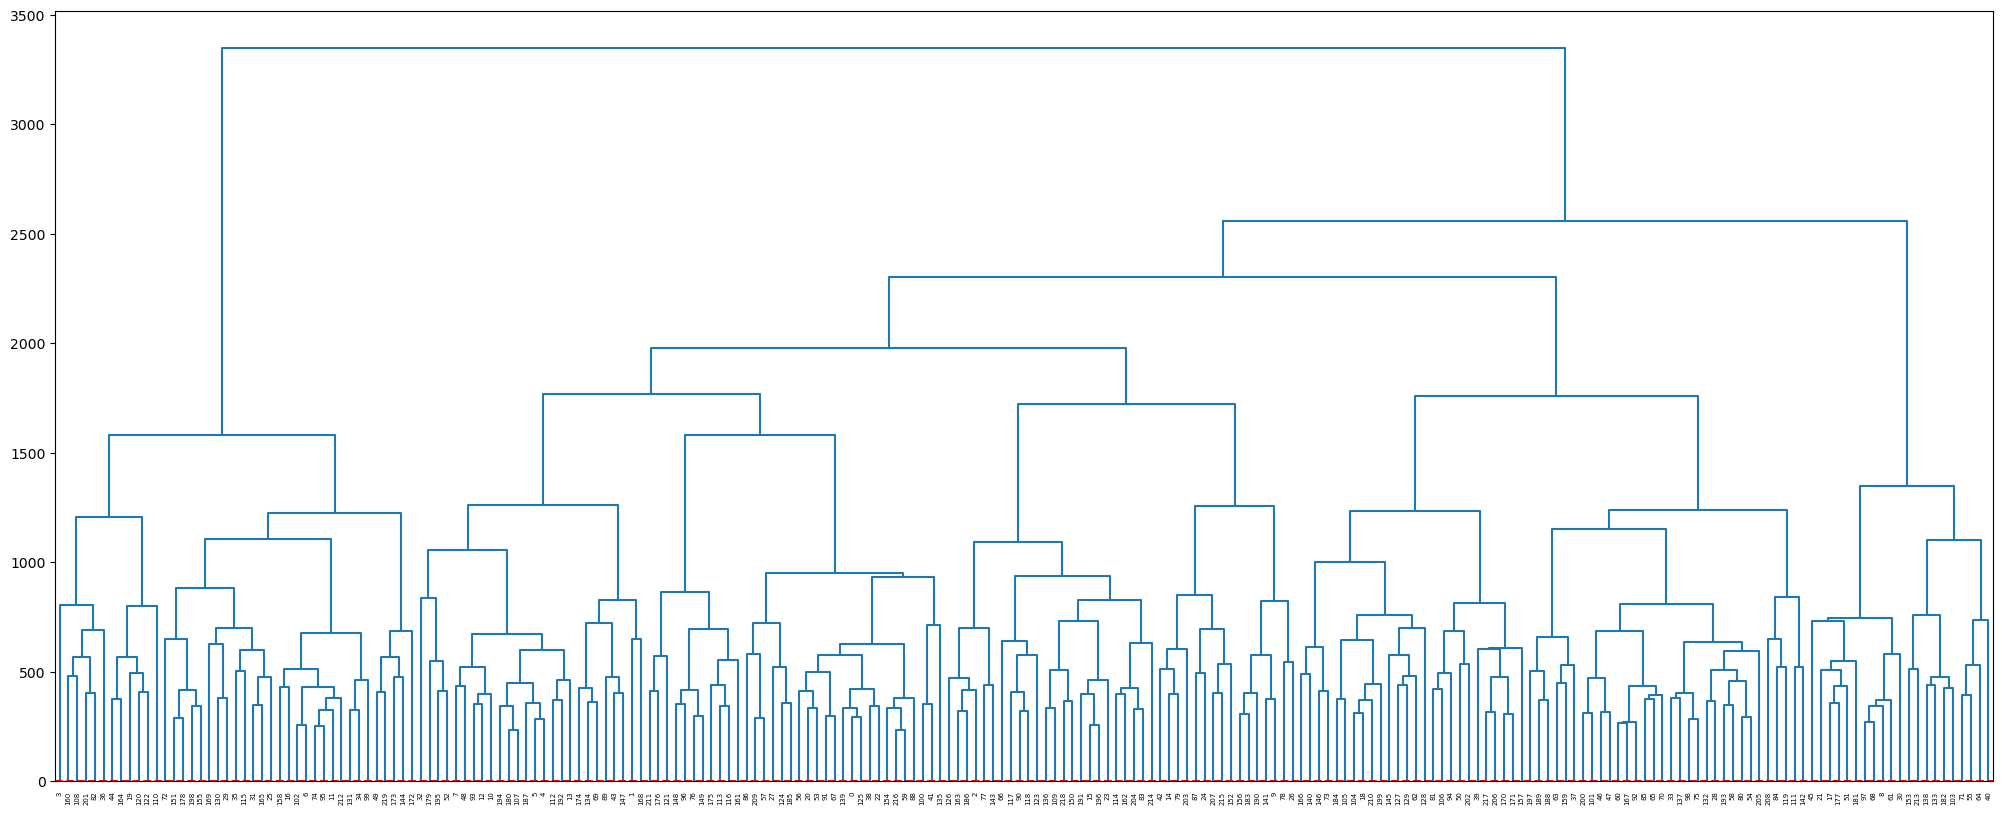

In [218]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

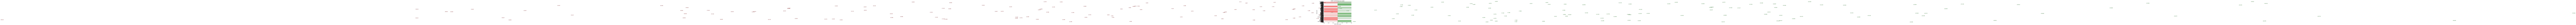

In [219]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [220]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [221]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

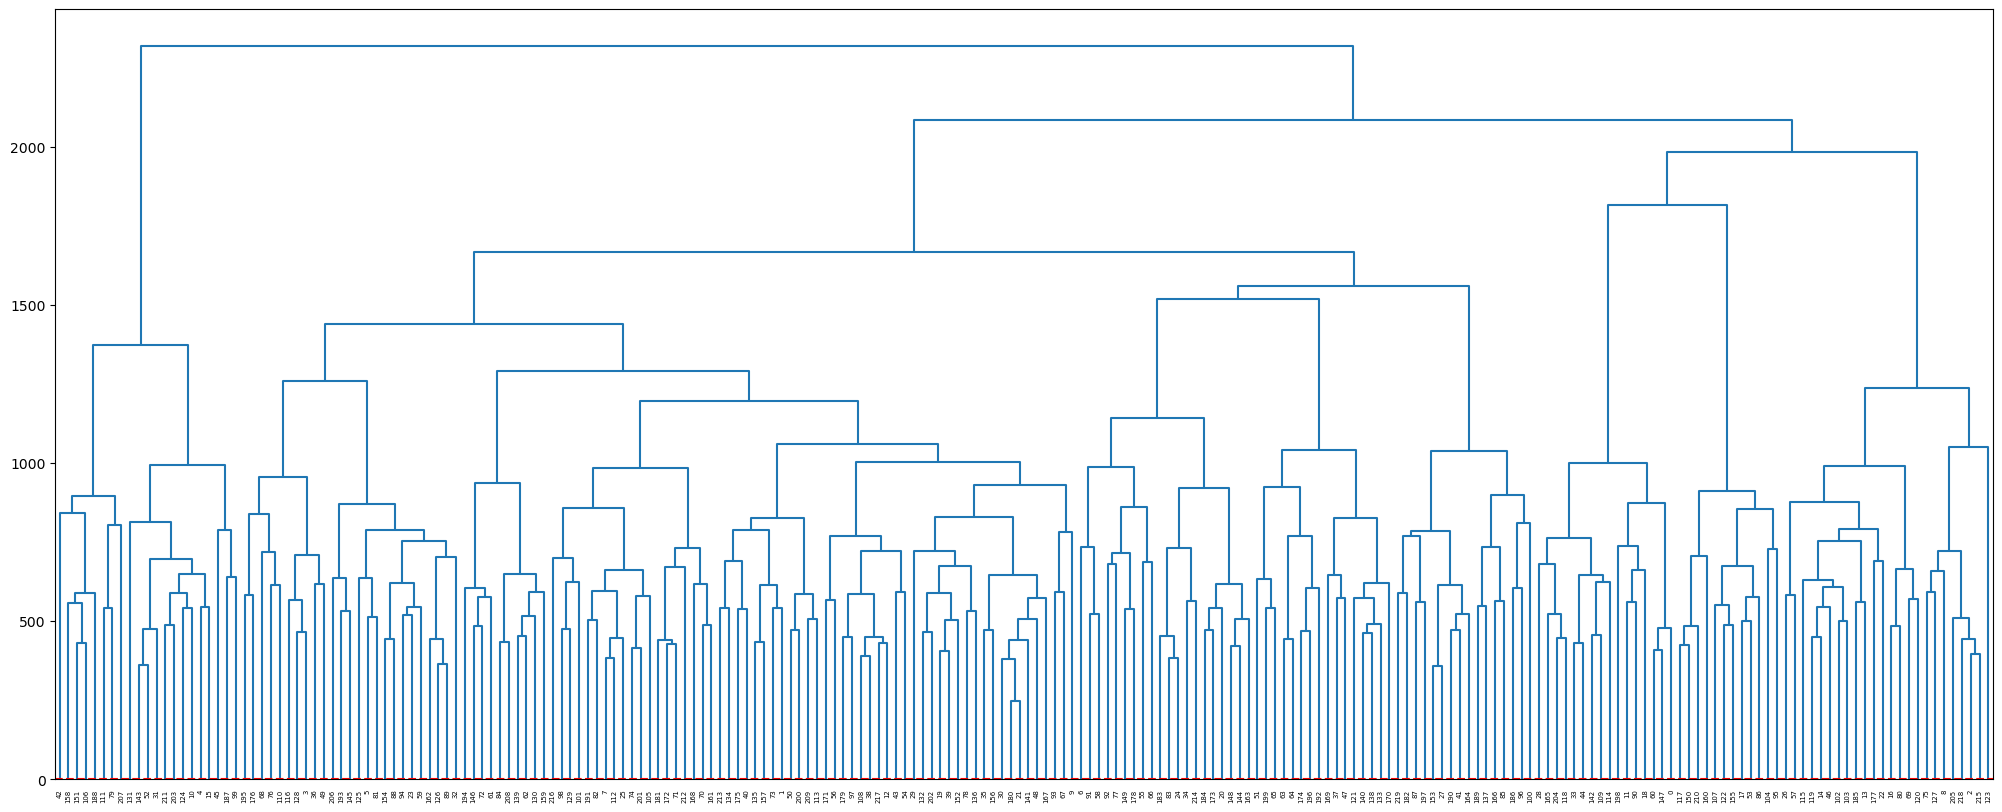

In [222]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [223]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 42, 158, 151, 106, 188, 111,  79, 207, 131, 143,  52,  31, 211,
       203, 124,  10,   4,  15,  45, 187,  99, 195, 176,  68,  76, 110,
       116, 128,   3,  36,  49, 206, 193, 145, 125,   5,  81, 154,  88,
        94,  23,  59, 162, 126,  89,  32, 194, 146,  72,  61,  84, 208,
       139,  62, 130, 159, 216,  98, 129, 101, 191,  82,   7, 112,  25,
        74, 201, 105, 181, 172,  71, 212, 168,  70, 161, 213, 134, 175,
        40, 135, 157,  73,   1,  50, 200, 209, 113, 171,  56, 179,  97,
       108,  38, 217,  12,  43,  54,  29, 132, 202,  19,  39, 152,  78,
       136,  35, 156,  30, 180,  21, 141,  48, 167,  93,  67,   9,   6,
        91,  58,  92,  77, 149, 178,  55,  66, 183,  83,  24,  34, 214,
       184, 173,  20, 148, 144, 163,  51, 199,  65,  63,  64, 174, 196,
       192, 169,  37,  47, 121, 140, 138, 133, 170, 219, 182,  87, 197,
       153,  27, 190,  41, 164, 189, 137, 166,  85, 186,  96, 100,  28,
       165, 204, 118,  33,  44, 142, 109, 114, 198,  11,  90,  1

In [224]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

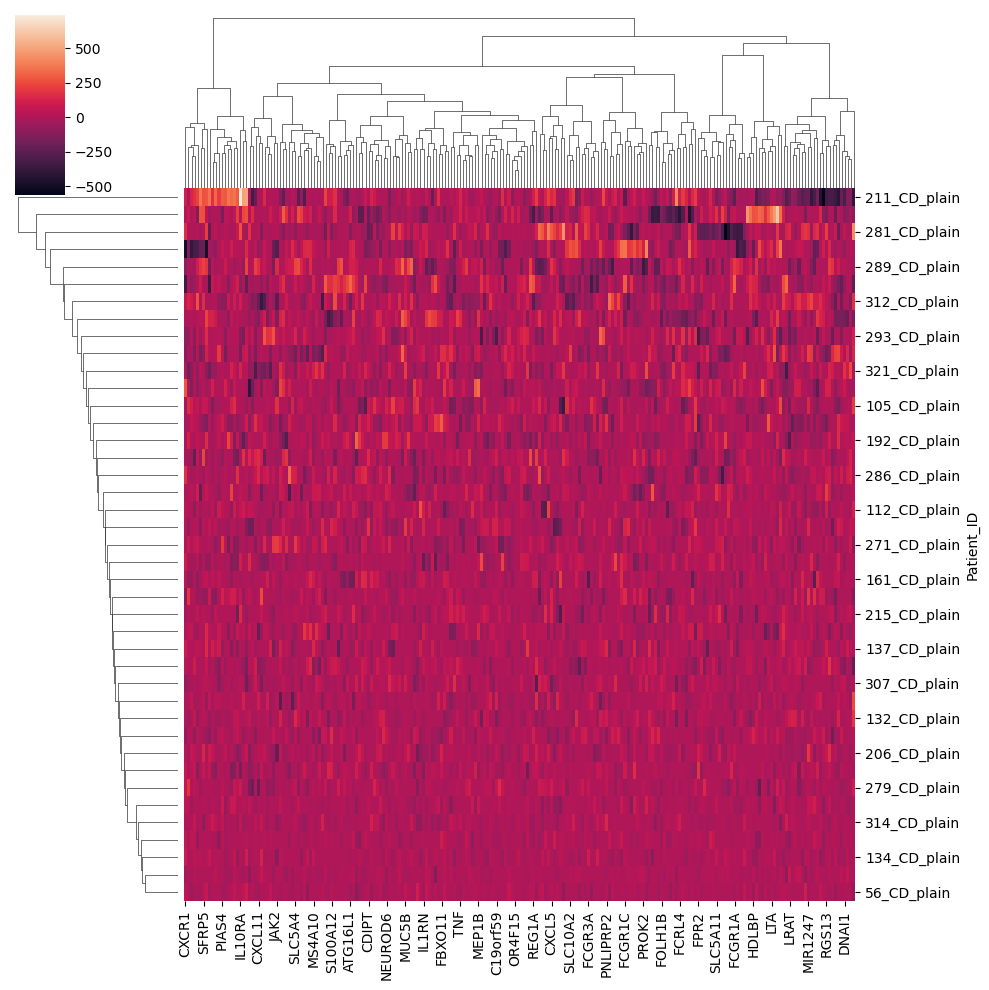

In [225]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [226]:
gene_cluster_cd_plain

array([[1.80000000e+02, 2.10000000e+01, 2.48175101e+02, 2.00000000e+00],
       [1.53000000e+02, 2.70000000e+01, 3.56457361e+02, 2.00000000e+00],
       [1.43000000e+02, 5.20000000e+01, 3.62021489e+02, 2.00000000e+00],
       [1.26000000e+02, 8.90000000e+01, 3.64803877e+02, 2.00000000e+00],
       [3.00000000e+01, 2.20000000e+02, 3.78789878e+02, 3.00000000e+00],
       [7.00000000e+00, 1.12000000e+02, 3.82983487e+02, 2.00000000e+00],
       [8.30000000e+01, 2.40000000e+01, 3.83979886e+02, 2.00000000e+00],
       [1.08000000e+02, 3.80000000e+01, 3.90452846e+02, 2.00000000e+00],
       [2.00000000e+00, 2.15000000e+02, 3.94308189e+02, 2.00000000e+00],
       [1.90000000e+01, 3.90000000e+01, 4.06489334e+02, 2.00000000e+00],
       [6.00000000e+01, 1.47000000e+02, 4.08703405e+02, 2.00000000e+00],
       [7.40000000e+01, 2.01000000e+02, 4.16099458e+02, 2.00000000e+00],
       [1.48000000e+02, 1.44000000e+02, 4.21917398e+02, 2.00000000e+00],
       [1.17000000e+02, 1.50000000e+02, 4.23991735e

In [227]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [228]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([151, 106, 158, 188,  42, 111,  79, 207, 143,  52,  31, 211, 203,
        124,  10,   4,  15, 131, 187,  99,  45, 195, 176,  76, 110,  68,
        128,   3, 116,  36,  49, 193, 145, 206,   5,  81, 125, 154,  88,
         94,  23,  59, 126,  89, 162,  32, 146,  72,  61, 194,  84, 208,
        139,  62, 130, 159,  98, 129, 101, 216, 191,  82,   7, 112,  25,
         74, 201, 105, 172,  71, 181, 212,  70, 161, 168, 213, 134, 175,
         40, 135, 157,  73,   1,  50, 200, 209, 113, 171,  56, 179,  97,
        108,  38, 217,  12,  43,  54, 132, 202,  19,  39, 152,  78, 136,
         29,  35, 156, 180,  21,  30, 141,  48, 167,  93,  67,   9,  91,
         58,   6,  92,  77, 149, 178,  55,  66,  83,  24, 183,  34, 214,
        184, 173,  20, 148, 144, 163, 199,  65,  51,  63,  64, 174, 196,
        192,  37,  47, 169, 140, 138, 133, 121, 170, 219, 182,  87, 197,
        153,  27, 190,  41, 164, 189, 137, 166,  85, 186,  96, 100, 204,
        118, 165,  28,  33,  44, 142, 109, 114,  11

In [229]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [230]:
cluster_labels

array([184,  83, 216,  28,  16,  35, 119,  63, 215, 116,  15, 178,  95,
       206, 200,  17, 209, 192, 180, 100, 133, 109, 208,  41, 127,  65,
       197, 158, 172, 105, 110,  11,  46, 173, 129, 106,  30, 145,  93,
       101,  79, 160,   5,  96, 174,  21, 201, 146, 112,  31,  84, 139,
        10, 193,  97, 124,  89, 198, 118,  42, 182,  49,  54, 140, 141,
       138, 125, 115,  26, 211,  73,  70,  48,  82,  66, 213,  24, 121,
       103,   7, 210,  36,  62, 126,  51, 165, 194, 155,  39,  44, 179,
       117, 120, 114,  40, 196, 167,  91,  57,  20, 168,  59, 202, 203,
       195,  68,   2, 191,  92, 176,  25,   6,  64,  87, 177, 204,  29,
       185, 170, 199, 212, 151, 189, 220,  14,  37,  43, 214,  27,  58,
        55,  18,  98, 150,  77,  80, 104, 163, 149,  53, 148, 111, 175,
         9, 135,  33,  47, 183, 134, 122, 186,   1, 102, 157,  38, 190,
       107,  81,   3,  56, 188,  74,  45, 136, 161, 171, 164, 113,  75,
       147, 152,  88,  69, 132, 142,  78,  23, 207, 123,  90, 10

In [231]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,1.475959,73.305053,-325.087257,0.000000,0.000000,18.004097,223.460081,AADAC,184
APOA1,41.0,1.786989,89.126791,-232.280597,-20.505644,0.000000,25.291848,261.811824,APOA1,83
APOA4,41.0,3.920843,59.772774,-209.710368,0.000000,0.000000,32.783449,147.022257,APOA4,216
APOB,41.0,-12.421235,67.155334,-251.596720,-35.077190,-1.655007,0.000000,188.562215,APOB,28
APOC3,41.0,16.125554,84.869342,-140.566691,-15.038718,3.814978,54.556928,350.235965,APOC3,16
...,...,...,...,...,...,...,...,...,...,...
NXF4,41.0,3.774179,61.428830,-128.804000,-24.789901,0.000000,0.000000,242.665469,NXF4,217
RNF125,41.0,6.358111,88.196652,-217.936008,-35.700804,0.000000,42.499911,314.871782,RNF125,60
DARS,41.0,-7.274293,55.314365,-126.799237,-26.702685,0.000000,11.978569,165.730092,DARS,94
DNAI1,41.0,-12.348654,74.564384,-305.594847,-16.243448,0.000000,10.023751,177.409485,DNAI1,218


In [232]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,1.475959,184,AADAC
APOA1,1.786989,83,APOA1
APOA4,3.920843,216,APOA4
APOB,-12.421235,28,APOB
APOC3,16.125554,16,APOC3
...,...,...,...
NXF4,3.774179,217,NXF4
RNF125,6.358111,60,RNF125
DARS,-7.274293,94,DARS
DNAI1,-12.348654,218,DNAI1


In [233]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,1.475959,184,AADAC
APOA1,1.786989,83,APOA1
APOA4,3.920843,216,APOA4
APOB,-12.421235,28,APOB
APOC3,16.125554,16,APOC3
...,...,...,...
NXF4,3.774179,217,NXF4
RNF125,6.358111,60,RNF125
DARS,-7.274293,94,DARS
DNAI1,-12.348654,218,DNAI1


In [234]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-8.423612,1,[C9orf71]
2,-5.881157,1,[CYP4F2]
3,7.359200,1,[SERPINA9]
4,4.516806,1,[CRYAB]
5,0.379504,1,[CXCR1]
...,...,...,...
216,3.920843,1,[APOA4]
217,3.774179,1,[NXF4]
218,-12.348654,1,[DNAI1]


In [235]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-8.423612,1,[C9orf71],C9orf71
2,-5.881157,1,[CYP4F2],CYP4F2
3,7.359200,1,[SERPINA9],SERPINA9
4,4.516806,1,[CRYAB],CRYAB
5,0.379504,1,[CXCR1],CXCR1
...,...,...,...,...
216,3.920843,1,[APOA4],APOA4
217,3.774179,1,[NXF4],NXF4
218,-12.348654,1,[DNAI1],DNAI1


In [236]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [237]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
5,-8.423612,1,[C9orf71],C9orf71
3,-5.881157,1,[CYP4F2],CYP4F2
1,7.359200,1,[SERPINA9],SERPINA9
2,4.516806,1,[CRYAB],CRYAB
4,0.379504,1,[CXCR1],CXCR1
...,...,...,...,...
219,3.920843,1,[APOA4],APOA4
218,3.774179,1,[NXF4],NXF4
216,-12.348654,1,[DNAI1],DNAI1
217,-20.817697,1,[LINC00342],LINC00342


In [238]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,7.359200,1,[SERPINA9],SERPINA9
2,4.516806,1,[CRYAB],CRYAB
3,-5.881157,1,[CYP4F2],CYP4F2
4,0.379504,1,[CXCR1],CXCR1
5,-8.423612,1,[C9orf71],C9orf71
...,...,...,...,...
216,-12.348654,1,[DNAI1],DNAI1
217,-20.817697,1,[LINC00342],LINC00342
218,3.774179,1,[NXF4],NXF4
219,3.920843,1,[APOA4],APOA4


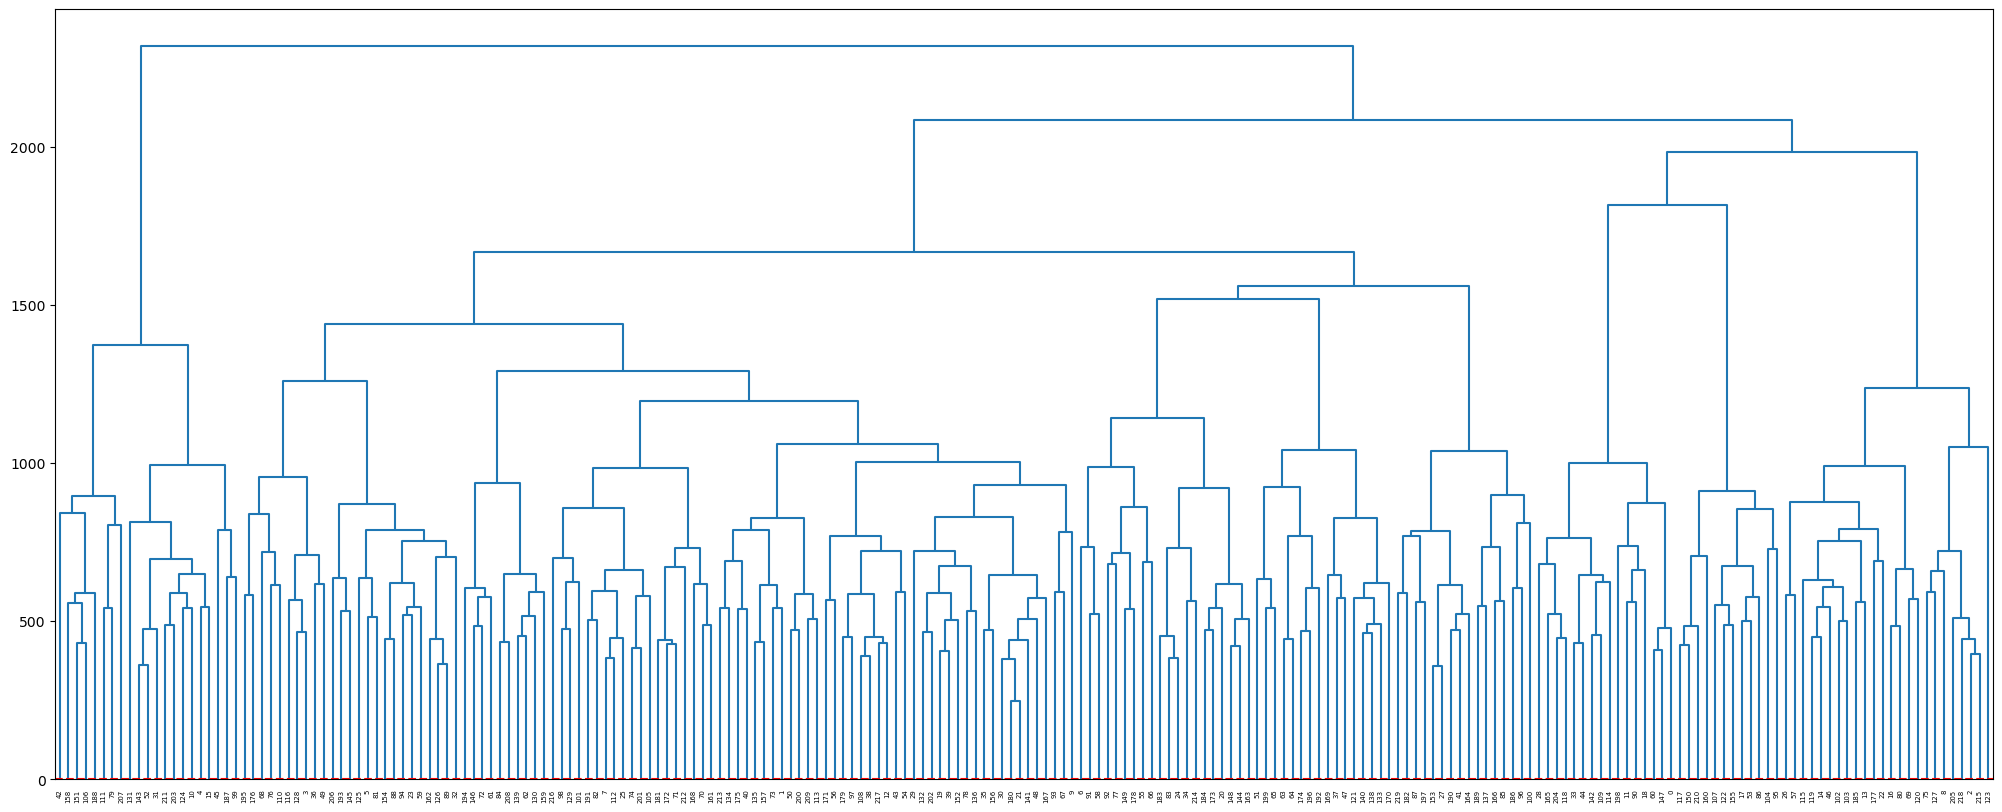

In [239]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

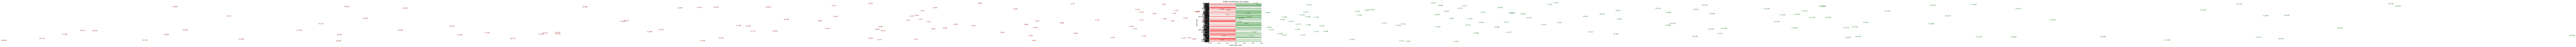

In [240]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [241]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")